Running ALS ...
Running SGD ...


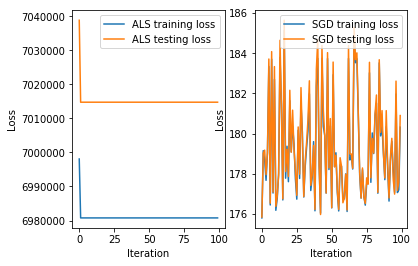

In [4]:
import numpy as np
from numpy import *
import matplotlib.pyplot as plt

num_users = 943
num_items = 1682


def SGD():
    k = 20

    learning_rate = 1e-4
    regularization_coefficient = 1e-2

    def loss(dataset, P, Q):
        error_square_sum = 0
        for sample in dataset:
            user_id, item_id, score = sample
            error = score - P[user_id - 1, :].dot(Q[item_index, :])
            error_square_sum += error ** 2

        loss = error_square_sum / dataset.shape[0] + regularization_coefficient * (np.sum(P ** 2) + np.sum(Q ** 2))
        return loss

    training_data = np.load("./ml-100k/data/u1_train_half.npy")
    testing_data = np.load("./ml-100k/data/u1_test_half.npy")

    P = np.random.random((num_users, k))
    Q = np.random.random((num_items, k))

    training_loss_history = []
    testing_loss_history = []

    iter = 0
    max_training_iteration = 100

    delta = 10e-8
    rho1 = 0.9
    rho2 = 0.999
    lr = 0.1
    s_p, s_q = 0, 0
    r_p, r_q = 0, 0
    for i in range(max_training_iteration):
        sample = training_data[np.random.randint(0, training_data.shape[0])]
        user_index = sample[0] - 1
        item_index = sample[1] - 1
        real_score = sample[2]

        predict_score = P[user_index, :].dot(Q[item_index, :])
        error = real_score - predict_score

        grad_p = -2 / training_data.shape[0] * (
                error * Q[item_index, :] + regularization_coefficient * P[user_index, :])
        grad_q = -2 / training_data.shape[0] * (
                error * P[user_index, :] + regularization_coefficient * Q[item_index, :])

        s_p = rho1 * s_p + (1 - rho1) * grad_p
        r_p = rho2 * r_p + (1 - rho2) * grad_p ** 2
        s_p_hat = s_p / (1 - rho1)
        r_p_hat = r_p / (1 - rho2)
        delta_p = (-learning_rate * s_p_hat) / (np.sqrt(r_p_hat) + delta)

        s_q = rho1 * s_q + (1 - rho1) * grad_q
        r_q = rho2 * r_q + (1 - rho2) * grad_q ** 2
        s_q_hat = s_q / (1 - rho1)
        r_q_hat = r_q / (1 - rho2)
        delta_q = (-learning_rate * s_q_hat) / (np.sqrt(r_q_hat) + delta)

        P[user_index, :] += delta_p
        Q[item_index, :] += delta_q

        training_loss = loss(training_data, P, Q)
        testing_loss = loss(testing_data, P, Q)

        training_loss_history.append(training_loss)
        testing_loss_history.append(testing_loss)
        # print(iter, training_loss, testing_loss)

        if iter > max_training_iteration:
            break
        iter += 1

    return iter, training_loss_history, testing_loss_history


def ALS():
    k = 8
    gamma = 1e0

    def loss(X, u, v):
        X_minus_uvT = X - u.dot(v.T)
        loss = np.sum(X_minus_uvT * X_minus_uvT)
        loss += gamma * (np.sum(u * u) + np.sum(v * v))

        return loss

    def compute_gradient(X, u, v, flag):
        if flag == 'U':
            math_item_1 = u.dot(v.T).dot(v)
            math_item_2 = X.dot(v)
            math_item_3 = gamma * u
            return 2 * (math_item_1 - math_item_2 + math_item_3)

        if flag == 'V':
            math_item_1 = v.dot(u.T).dot(u)
            math_item_2 = X.T.dot(u)
            math_item_3 = gamma * v
            return 2 * (math_item_1 - math_item_2 + math_item_3)

    R = np.load("./ml-100k/data/u1_train.npy")
    U = np.random.random((num_users, k))
    V = np.random.random((num_items, k))
    R_test = np.load("./ml-100k/data/u1_test.npy")

    training_losses = []
    testing_losses = []
    training_max_iterations = 100
    for i in range(training_max_iterations):
        if i % 2 == 0:
            '''
            grad_U = compute_gradient(R, U, V, 'U')
            U -= learning_rate * grad_U
            '''

            temp = V.T.dot(V) + gamma * np.eye(k)
            temp_mat = mat(temp)
            # U = R.dot(V).dot(array(temp_mat.I))

            for j in range(U.shape[1]):
                U[j, :] = array(temp_mat.I).dot(V.T).dot(R[j, :])

        if i % 2 == 1:
            '''
            grad_V = compute_gradient(R, U, V, 'V')
            V -= learning_rate * grad_V
            '''
            temp = U.T.dot(U) + gamma * np.eye(k)
            temp_mat = mat(temp)
            # V = R.T.dot(U).dot(array(temp_mat.I))

            for j in range(V.shape[1]):
                V[j, :] = array(temp_mat.I).dot(U.T).dot(R[:, j])

        new_train_loss = loss(R, U, V)
        new_test_loss = loss(R_test, U, V)
        training_losses.append(new_train_loss)
        testing_losses.append(new_test_loss)
        # print(i, new_train_loss, new_test_loss)

    return training_max_iterations, training_losses, testing_losses


if __name__ == '__main__':
    plt.subplot(121)
    print("Running ALS ...")
    ALS_max_iter, ALS_training_loss, ALS_testing_loss = ALS()
    ALS_max_iter = np.arange(ALS_max_iter)
    plt.plot(ALS_max_iter, ALS_training_loss, label='ALS training loss')
    plt.plot(ALS_max_iter, ALS_testing_loss, label='ALS testing loss')

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(122)
    print("Running SGD ...")
    SGD_max_iter, SGD_training_loss, SGD_testing_loss = SGD()
    SGD_max_iter = np.arange(SGD_max_iter)
    plt.plot(SGD_max_iter, SGD_training_loss, label='SGD training loss')
    plt.plot(SGD_max_iter, SGD_testing_loss, label='SGD testing loss')

    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()